# Fashion MNIST with CNNs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

/home/user/anaconda3/envs/torch_env/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
!pwd

/home/user/Documents/PhD/Train/pytorch/tutorial/basics


## Dataset

In [3]:
# load data from datasets module of torchvision
transform =  transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ]
)

# divide the dataset into train, test and validation
# train -> empirical risk
# test -> test risk (estimate of the population risk)
# validation -> used for model selection (we choose the model with minimum validation loss)

tmp_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transform, # directly transform the Image (PIL.Image) into a torch.Tensor
)

train_data, val_data = torch.utils.data.random_split(
    tmp_data,
    [0.85, 0.15]
) # random_split generates SubSet objects, to access the use the `dataset` member

train_data, val_data = train_data.dataset, val_data.dataset

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transform,
)

In [4]:
# show all the ancestors classes of FashionMNIST class
# note that we have the DataSet class between the acnestors
display(type(train_data).__mro__)

(torchvision.datasets.mnist.FashionMNIST,
 torchvision.datasets.mnist.MNIST,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

As we see, the dataset class inherits from the basic PyTorch class `DataSet`.
All subclasses should overwrite `__getitem__()`, supporting fetching a data sample for a given key (which is usually an `int`).

In [5]:
feature_shape = train_data.__getitem__(0)[0].shape
n_channels = feature_shape[0]
n_pixely = feature_shape[1]
n_pixelx = feature_shape[2]
classes = train_data.classes
n_classes = len(classes)

print(f'Feature shape {tuple(feature_shape)}')
print(f'{n_classes} classes:')
print(tmp_data.classes)

Feature shape (1, 28, 28)
10 classes:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


,name,count
0,T-shirt/top,6000
1,Trouser,6000
2,Pullover,6000
3,Dress,6000
4,Coat,6000
5,Sandal,6000
6,Shirt,6000
7,Sneaker,6000
8,Bag,6000
9,Ankle boot,6000


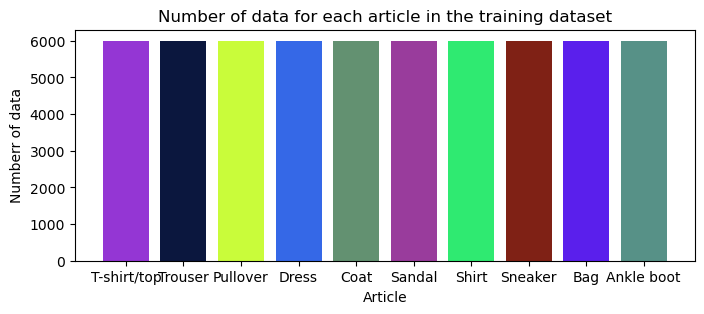

In [6]:
train_labels = train_data.targets
# Tensor.unique returns a tuple with one array of elements and another array with caounts
# thus the following line returns a dict with class names as keys and counts as values
count_dict = dict(zip(*train_labels.unique(return_counts=True))) 

count_df = pd.DataFrame(
    {
        'name':  [train_data.classes[l] for l in count_dict.keys()],
        'count': map(int,count_dict.values())
    }
)
display(count_df)

# generate a color for each dataframe row
colors = np.random.rand(len(count_df),4)
colors[:,3]=1.

plt.figure(figsize=(8,3))
plt.bar(
    x = count_df['name'],
    height = count_df['count'],
    color=colors
)
plt.xlabel('Article')
plt.ylabel('Numberr of data')
plt.title('Number of data for each article in the training dataset')

plt.show()

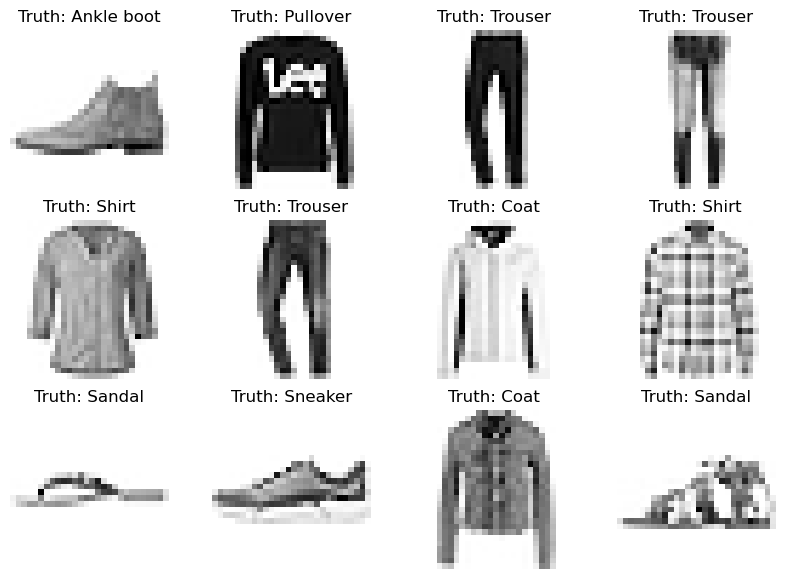

In [7]:
n_rows_subplots = 3
n_cols_subplots = 4
dim_x = 10
dim_y = 7

######### Show a grid of images #########

def imshow_format(image):
    """
    Transform image format from (C, M, N) to (M, N, C),
    as a matplotlib.pyplot.imshow X argument
    """
    return image.permute([1,2,0])
    
def show_images_greys(
    image_dataset,
    n_rows_subplots=2,
    n_cols_subplots=2,
    dim_x=6,
    dim_y=6
):
    """
    Show a grid of images
    """
    
    fig, axes = plt.subplots(n_rows_subplots, n_cols_subplots, figsize=(dim_x, dim_y))

    image_subset = [image_dataset[i] for i in range(n_rows_subplots*n_cols_subplots)]
    axes = axes.flatten()
    
    for ax, image in zip(axes, image_subset):
        ax.imshow(imshow_format(image[0]), cmap='Greys')
        ax.set_title(rf'Truth: {classes[image[1]]}') # image[1] is the label
        ax.axis('off')

    return fig,axes

#########################################

fig,axes = show_images_greys(
    test_data,
    n_rows_subplots,
    n_cols_subplots,
    dim_x,
    dim_y
)


## Dataloader

In [8]:
# Set the batch size
batch_size = 64

# Create the loaders
train_loader = DataLoader(train_data, batch_size=batch_size,num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Show all the images in a batch to have a quick hint of the data morphology

In [9]:
# helper function to show an image
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

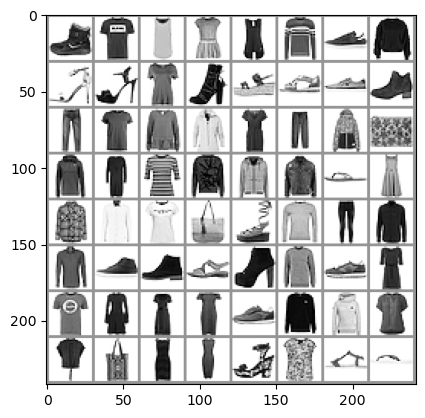

In [10]:
# rapidly show all the images of a batch
data_iter = iter(train_loader)
images, labels = next(data_iter)
# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

Checking for available GPU device

In [11]:
if torch.cuda.is_available():
    device = 'cuda'
    print('Selected %s' % (device))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

## Model: CNN

To define a neural network in PyTorch, we need a class inheriting from `nn.Module`. The layers of the network are defined in the `__init__` function. Then we specify how data will pass through the network in the `forward` function 

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(676, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# assign a device in which you run the network    
model = Net().to(device)

In [13]:
def model_count_params(model):
    return np.sum([s.numel() for s in model.parameters()])
writer = SummaryWriter('runs/F-MNIST_CNN-3')

In [14]:
writer.add_scalar("model/size", model_count_params(model))
print("Model size:", model_count_params(model))
writer.add_graph(model, images.to(device))

Model size: 68750


In [15]:
# Delve into the morphology of te layers
for i,p in enumerate(model.parameters()):
    print(f'Layer {i}:\n shape {p.shape},\n number of parameters {p.numel()}')
model.parameters()

Layer 0:
 shape torch.Size([4, 1, 3, 3]),
 number of parameters 36
Layer 1:
 shape torch.Size([4]),
 number of parameters 4
Layer 2:
 shape torch.Size([100, 676]),
 number of parameters 67600
Layer 3:
 shape torch.Size([100]),
 number of parameters 100
Layer 4:
 shape torch.Size([10, 100]),
 number of parameters 1000
Layer 5:
 shape torch.Size([10]),
 number of parameters 10


<generator object Module.parameters at 0x7ceae45726c0>

#### Loss: Negative log-likelihood axa cross-entropy

In [16]:
def accuracy(y_true, y_pred):
    """
    calculates the accuracy of the prediction
    y_true is N-vector of integers for N-item batch
    y_pred is a tensor N x 10 of 10-dimensional network component output
    
    You have to find the number of the highest component output
    and compare it with y_true and compute average number of exact matches.
    
    Returs: average number of exact matches 
    """
    # to find maximum item in the tensor along i dimension use .max(dim=i)
    # to count number of matching items use '==' operator
    # 
    ### BEGIN SOLUTION
    n_pred = y_pred.max(dim=1)[1]
    accuracy = torch.sum(y_true == n_pred).item()/len(y_true)
    ### END SOLUTION
    
    return accuracy

In [17]:
assert accuracy(torch.ones(1000), torch.rand(1000,2)) > 0.4 
assert accuracy(torch.ones(1000), torch.rand(1000,2)) < 0.6
assert accuracy(torch.ones(10), torch.cat([torch.ones(10,1), torch.zeros(10,1)], dim=1)) == 0
assert accuracy(torch.ones(10), torch.cat([torch.zeros(10,1), torch.ones(10,1)], dim=1)) == 1

In [18]:
# helper functions
def plot_classes_preds(net, images, labels, classes):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 12))
    for idx in np.arange(16):
        ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
#       plt.cla()
    return fig

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

In [19]:
def train(model, writer, num_epochs=1, device='cpu'):
    # select the optimization algorithm with realive hyperparameters
    optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
    # select the loss (for classification usually cross-entropy loss)
    criterion = nn.CrossEntropyLoss()

    train_loss = []
    validation_loss = []
    test_accuracy = []
    running_loss = 0.

    epoch_iter = tqdm.trange(num_epochs)
    for epoch in epoch_iter:
        for i, data in enumerate(train_loader, 0):
            
            # get the inpputs; data is a list of [inputs, labels]
            inputs, labels = map(lambda x: x.to(device), data)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward +  backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i%100 == 99:
                writer.add_scalar(
                    'Loss/Training',
                    running_loss / 1000,
                    epoch * len(train_loader) + i
                )
                running_loss = 0.0
                fig = plot_classes_preds(model, inputs, labels, test_data.classes)
                writer.add_figure('predictions vs. actuals', fig, global_step=epoch * len(train_loader) + i)
                plt.close(fig)
                del fig
        
        for X_batch, y_batch in DataLoader(val_data, batch_size=len(val_data)):
            test_accuracy.append(
                accuracy(
                    y_batch.to(device),
                    model(X_batch.to(device))
                )
            )
            writer.add_scalar(
                'Loss/val',
                test_accuracy[-1],
                epoch
            )

            epoch_iter.set_description(f'Accuracy: {test_accuracy[-1]:.3f}')
            plt.close('all')

In [20]:
# if you get RuntimeWarning: More than 20 figures have been opened., don't worry, all figures are closed at the end of train proc
train(model, writer, num_epochs=10, device=device)

Accuracy: 0.867: 100%|██████████| 10/10 [02:58<00:00, 17.89s/it]


In [22]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 39890), started 0:15:48 ago. (Use '!kill 39890' to kill it.)

### Final test

In [30]:
def test_model(model, writer):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_accuracy = 0
    cpu_model = model.to('cpu')
    cpu_model.train(False)
    with torch.no_grad():
        for X_batch, y_batch in DataLoader(test_data, batch_size=len(test_data)):
            output = cpu_model(X_batch)
            test_accuracy = 100 * accuracy(y_batch, output)
            _, pred = torch.max(output, 1)
            correct_tensor = pred.eq(y_batch.data.view_as(pred))
            correct = np.squeeze(correct_tensor.cpu().numpy())
            for i in range(len(y_batch)):
                label = y_batch.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1


    print("Final results:")
    print(f"  test accuracy:\t\t{test_accuracy:.2f}")

    if test_accuracy > 98:
        print("U'r freakin' amazin'!")
    elif test_accuracy > 95:
        print("Achievement unlocked: 110lvl Warlock!")
    elif test_accuracy > 90:
        print("Achievement unlocked: 80lvl Warlock!")
    elif test_accuracy > 85:
        print("Achievement unlocked: 70lvl Warlock!")
    else:
        print("We need more magic! Follow instructons below")
    
    print("-" * 40)
    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                test_data.classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
        
    writer.add_scalar("Loss/test", test_accuracy)
    return test_accuracy

In [51]:

%time acc = test_model(model, writer)
assert acc > 80
writer.close()


Final results:
  test accuracy:		85.07
Achievement unlocked: 70lvl Warlock!
----------------------------------------
Test Accuracy of T-shirt/top: 76% (767/1000)
Test Accuracy of Trouser: 93% (937/1000)
Test Accuracy of Pullover: 67% (676/1000)
Test Accuracy of Dress: 92% (920/1000)
Test Accuracy of  Coat: 79% (799/1000)
Test Accuracy of Sandal: 93% (934/1000)
Test Accuracy of Shirt: 64% (641/1000)
Test Accuracy of Sneaker: 96% (964/1000)
Test Accuracy of   Bag: 95% (951/1000)
Test Accuracy of Ankle boot: 91% (918/1000)
CPU times: user 2.33 s, sys: 274 ms, total: 2.61 s
Wall time: 1.83 s


## Task: improve convolution net

Let's create a mini-convolutional network with an architecture like this:

* 3x3 convolution with 8 filters, padding=1 and _ReLU_ activation
* 2x2 pooling
* 3x3 convolution with 16 filters, padding=1 and _ReLU_ activation
* 4x4 pooling
* flatten
* Linear layer with ~180 input and ~100 output sizes and _ReLU_ activation
* output linear layer


To find the size of the 1st linear layer you can run the cell below and 
if it throws error like this: 

    RuntimeError: size mismatch, m1: [32 x 784], m2: [144 x 100], 
  
you should change the size of the Linear layer to 784.

Once you're done, train it with __Adam__ optimizer with default params (feel free to modify the `train` procedure above).


__TIP_OF_THE_DAY__: the number of channels must be similar to the number of classes (same order of magnitude).

In [52]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # put all the layer initialization here
        ### BEGIN SOLUTION
        self.conv1 = nn.Conv2d(1,  8,  3, padding=1)
        self.conv2 = nn.Conv2d(8,  16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 10)
        ### END SOLUTION

    def forward(self, x):
        # pass x through all the layers
        ### BEGIN SOLUTION
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        ### END SOLUTION
        return x
    
model2 = Net2().to(device)

In [53]:
for p in model2.parameters():
    print(p.shape)

torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([300, 784])
torch.Size([300])
torch.Size([10, 300])
torch.Size([10])


## Train it ##

In [54]:
writer2 = SummaryWriter('runs/F-MNIST_CNN-redux-1')
writer2.add_scalar("model/size", model_count_params(model2))
writer2.add_graph(model2, images.to(device))
writer2.close()

In [55]:
model_count_params(model2)

239758

In [56]:
train(model2, writer2, num_epochs=20, device=device)

Accuracy: 0.915: 100%|██████████| 20/20 [08:30<00:00, 25.55s/it]


## Test it

In [57]:
%time acc = test_model(model2, writer2);
writer2.close()
assert acc > 90

Final results:
  test accuracy:		89.70
Achievement unlocked: 70lvl Warlock!
----------------------------------------
Test Accuracy of T-shirt/top: 83% (835/1000)
Test Accuracy of Trouser: 97% (971/1000)
Test Accuracy of Pullover: 81% (811/1000)
Test Accuracy of Dress: 94% (943/1000)
Test Accuracy of  Coat: 83% (830/1000)
Test Accuracy of Sandal: 97% (977/1000)
Test Accuracy of Shirt: 70% (703/1000)
Test Accuracy of Sneaker: 97% (974/1000)
Test Accuracy of   Bag: 97% (977/1000)
Test Accuracy of Ankle boot: 94% (949/1000)
CPU times: user 4.1 s, sys: 516 ms, total: 4.61 s
Wall time: 2.55 s


AssertionError: 

Hopefully you've managed to succeed. If not, you may always come back to this task after looking at at more advanced topics, e.g. regularization and batch normalization.

**Question**: What are your model's weaknesses and how might they be improved?

**Answer**: This model seems to do best on boots rather than coats. For example, it does best on the Sandal class and worst on the Shirt class. Maybe it's because Shirts vary in size and so it would improve this model if you could increase the number of shirt images in the first place or perhaps if one added another convolutional layer to detect finer patterns in these images. One could also experiment with a smaller learning rate so that the model takes small steps in the right direction as it is training.

Images with correct and predicted labels like the one below are stored in Tensorboard images during the training.